In [40]:
pip install  openpyxl

Note: you may need to restart the kernel to use updated packages.


# Importer les librairies necessaires pour le projet

In [41]:
import pandas as pd
import json
import matplotlib.pyplot as plt


# Charger le dataset et afficher les infos et les 5 premieres lignes

In [42]:
file_name = 'logs_matching.xlsx'
df = pd.read_excel(file_name)
d1 = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   dt                  3129 non-null   datetime64[ns]
 1   name                3129 non-null   object        
 2   customDimensions    3129 non-null   object        
 3   customMeasurements  1117 non-null   object        
 4   operation_Id        3129 non-null   object        
 5   operation_ParentId  3129 non-null   object        
 6   session_Id          3129 non-null   object        
 7   user_Id             3129 non-null   object        
 8   client_City         3125 non-null   object        
dtypes: datetime64[ns](1), object(8)
memory usage: 220.1+ KB


In [43]:
df.head()

,dt,name,customDimensions,customMeasurements,operation_Id,operation_ParentId,session_Id,user_Id,client_City
0,2024-10-21 15:01:43,search-job,"{""candidateId"":""14803365"",""useCase"":""ags"",""res...","{""totalCount"":11,""noMatchWarning"":1}",fc59e8f75b0347ffaa6008ca32f0e214,fc59e8f75b0347ffaa6008ca32f0e214,xaj4upL15UqOAXq0WV7LGq,dijr2pcbZo4dIAYgE+aELl,Paris
1,2024-10-21 15:01:43,search-job,"{""candidateId"":""14803365"",""useCase"":""ags"",""res...","{""totalCount"":11,""noMatchWarning"":1}",fc59e8f75b0347ffaa6008ca32f0e214,fc59e8f75b0347ffaa6008ca32f0e214,xaj4upL15UqOAXq0WV7LGq,dijr2pcbZo4dIAYgE+aELl,Paris
2,2024-10-21 15:01:43,sort-results,"{""candidateId"":""14803365"",""searchId"":""cTUjiyDr...",NaN,fc59e8f75b0347ffaa6008ca32f0e214,fc59e8f75b0347ffaa6008ca32f0e214,xaj4upL15UqOAXq0WV7LGq,dijr2pcbZo4dIAYgE+aELl,Paris
3,2024-10-21 15:01:43,search-job,"{""candidateId"":""14803365"",""useCase"":""ags"",""res...","{""totalCount"":11,""noMatchWarning"":1}",fc59e8f75b0347ffaa6008ca32f0e214,fc59e8f75b0347ffaa6008ca32f0e214,xaj4upL15UqOAXq0WV7LGq,dijr2pcbZo4dIAYgE+aELl,Paris
4,2024-10-21 15:03:43,click-link,"{""searchId"":""cTUjiyDrwpHwzp87Rr2Qq"",""url"":""htt...",NaN,fc59e8f75b0347ffaa6008ca32f0e214,fc59e8f75b0347ffaa6008ca32f0e214,xaj4upL15UqOAXq0WV7LGq,dijr2pcbZo4dIAYgE+aELl,Paris


# Convertir `customDimensions` et `customMeasurements` en dictionnaire JSON pour faciliter l'analyse

In [44]:
df["customDimensions"] = df["customDimensions"].apply(lambda x: json.loads(x) if isinstance(x, str) else {})
df["customMeasurements"] = df["customMeasurements"].apply(lambda x: json.loads(x) if isinstance(x, str) else {})


# 1️) Nombre total de recherches

In [45]:
total_searches = df[df["name"] == "search-job"].shape[0]
print(f"Nombre total de recherches: {total_searches}\n")


Nombre total de recherches: 2220




# 2) Détection des erreurs

####                 I) Les erreurs de search-job

In [46]:
pattern = r'"usecaseError":"422'
s = d1[(d1['name'] == 'search-job') & (d1["customDimensions"].str.contains(pattern))].shape[0]
print(f"\n\nNombre d'erreurs de recherche de jobs: {s}")




Nombre d'erreurs de recherche de jobs: 498


#### II) Click-link pattern respecté

In [47]:
p = r'{"searchId":"[^"]+","url":"[^"]+"}'

link = d1[(d1['name'] == 'click-link') & (d1["customDimensions"].str.contains(p))].shape[0]
print("\n\nLe format Click link est respecté: ",link == d1[(d1['name'] == 'click-link')].shape[0])



Le format Click link est respecté:  True


#### III) Sort-job pattern respecté

In [48]:
p = r'{"candidateId":"[^"]+","searchId":"[^"]+","sortType":"[^"]+","sortedOffers":"\[[^\]]+\]"}'

sort = d1[(d1['name'] == 'sort-job') & (d1["customDimensions"].str.contains(p))].shape[0]
print("\n\nLe format Sort job est respecté: ",sort == d1[(d1['name'] == 'sort-job')].shape[0])



Le format Sort job est respecté:  True


# 3) Nombre de candidats uniques

In [56]:

df["candidateId"] = df["customDimensions"].apply(lambda x: x.get("candidateId", None))
unique_candidates = df["candidateId"].nunique()
print(f"Nombre de candidats uniques: {unique_candidates}\n")



Nombre de candidats uniques: 275



# 4) Nombre moyen d'offres retournées par candidat

In [50]:
search_jobs = df[df["name"] == "search-job"]
search_jobs = search_jobs.copy()
search_jobs["totalCount"] = search_jobs["customMeasurements"].apply(lambda x: x.get("totalCount", 0))
avg_offers_per_candidate = search_jobs.groupby("candidateId")["totalCount"].mean().mean()
print(f"Nombre moyen d'offres par candidat: {avg_offers_per_candidate:.2f}\n")



Nombre moyen d'offres par candidat: 67.68



# 5) Analyse des feedbacks (likes, dislikes, neutral, null)

In [51]:
feedback_jobs = df[df["name"] == "feedback-search-job"]
feedback_jobs = feedback_jobs.copy()
feedback_jobs["like"] = feedback_jobs["customDimensions"].apply(lambda x: x.get("like", "null"))
feedback_counts = feedback_jobs["like"].value_counts()

print("Répartition des feedbacks:\n", feedback_counts)



Répartition des feedbacks:
 like
dislike    48
like       38
neutral    15
null        5
Name: count, dtype: int64


# 6) Extraction des raisons des dislikes

In [52]:
dislike_reasons = feedback_jobs[feedback_jobs["like"] == "dislike"]["customDimensions"].apply(lambda x: x.get("feedback", "Inconnue"))
reason_counts = dislike_reasons.value_counts()
print("\nLes raisons des dislikes:\n", reason_counts)




Les raisons des dislikes:
 customDimensions
Les compétences du candidat ne sont pas du tout en lien avec le job    31
mauvaise distance                                                       4
alternance                                                              3
offre plus en ligne                                                     2
OFFRE PLUS EN LIGNE                                                     2
alternance refusé par tt                                                1
annonce plus en ligne                                                   1
plus en ligne                                                           1
Localisation de l'agence Tarascon par rapport à la mission              1
AGENCE DE LA ROCHELLE ME SIGNALE QUE L'OFFRE N'EST PLUS D'ACTUALITE     1
Distance inadequate                                                     1
Name: count, dtype: int64


In [53]:
reason_counts_freq = (reason_counts * 100 / reason_counts.sum()).round(2)
print("\nPourcentage des raisons des dislikes:\n", reason_counts_freq)


Pourcentage des raisons des dislikes:
 customDimensions
Les compétences du candidat ne sont pas du tout en lien avec le job    64.58
mauvaise distance                                                       8.33
alternance                                                              6.25
offre plus en ligne                                                     4.17
OFFRE PLUS EN LIGNE                                                     4.17
alternance refusé par tt                                                2.08
annonce plus en ligne                                                   2.08
plus en ligne                                                           2.08
Localisation de l'agence Tarascon par rapport à la mission              2.08
AGENCE DE LA ROCHELLE ME SIGNALE QUE L'OFFRE N'EST PLUS D'ACTUALITE     2.08
Distance inadequate                                                     2.08
Name: count, dtype: float64


# 📊 Visualisation des données

## Repartition des feedbacks

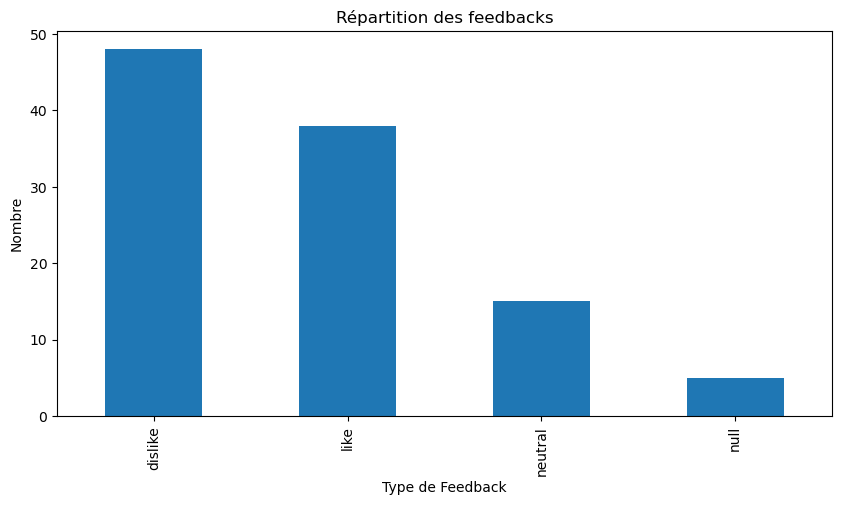

In [54]:
plt.figure(figsize=(10, 5))
feedback_counts.plot(kind='bar', title='Répartition des feedbacks')
plt.xlabel('Type de Feedback')
plt.ylabel('Nombre')
plt.show()


## Raisons des dislikes

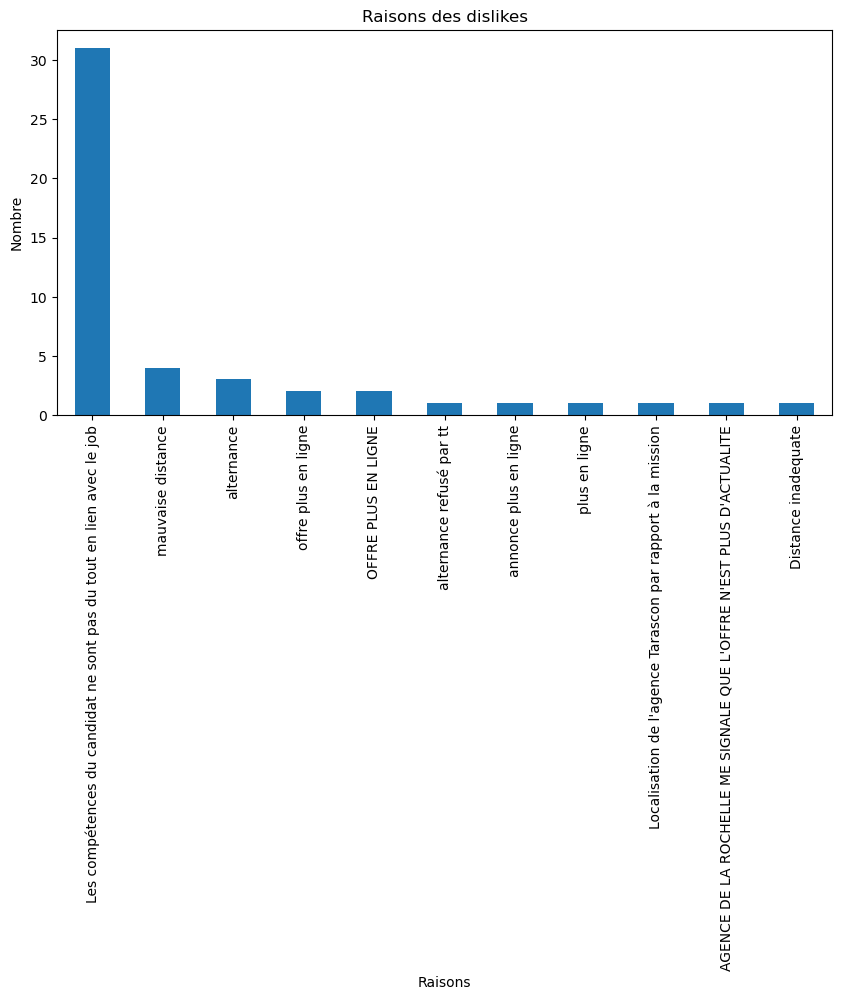

In [55]:

if not reason_counts.empty:
    plt.figure(figsize=(10, 5))
    reason_counts.plot(kind='bar', title='Raisons des dislikes')
    plt.xlabel('Raisons')
    plt.ylabel('Nombre')
    plt.show()
